# All imports

In [ ]:
import cv2
import os
import random
from google.colab import drive
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Drive Set up

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
input_dirs = {
    'rotten': '/content/drive/MyDrive/data/rotten',
    'mid': '/content/drive/MyDrive/data/mid',
    'fresh': '/content/drive/MyDrive/data/fresh'
}

In [ ]:
output_dirs = {
    'rotten': '/content/drive/MyDrive/data/rotten_frames',
    'mid': '/content/drive/MyDrive/data/mid_frames',
    'fresh': '/content/drive/MyDrive/data/fresh_frames'
}

In [ ]:
for category, out_dir in output_dirs.items():
    os.makedirs(out_dir, exist_ok=True)

# Dataset Preparation

In [ ]:
fresh_frames_dir = '/content/drive/MyDrive/data/fresh_frames'
mid_frames_dir = '/content/drive/MyDrive/data/mid_frames'
rotten_frames_dir = '/content/drive/MyDrive/data/rotten_frames'

fresh_images_count = len([file for file in os.listdir(fresh_frames_dir) if file.endswith('.jpg')])
mid_images_count = len([file for file in os.listdir(mid_frames_dir) if file.endswith('.jpg')])
rotten_images_count = len([file for file in os.listdir(rotten_frames_dir) if file.endswith('.jpg')])

print(f"Number of images in fresh_frames: {fresh_images_count}")
print(f"Number of images in mid_frames: {mid_images_count}")
print(f"Number of images in rotten_frames: {rotten_images_count}")

Number of images in fresh_frames: 110
Number of images in mid_frames: 130
Number of images in rotten_frames: 60


## Data preprocessing

In [ ]:
base_path = "/content/drive/MyDrive/data/augmented"

folders = {
    "fresh": "augmented_fresh_frames",
    "mid": "augmented_mid_frames",
    "rotten": "augmented_rotten_frames"
}

for label, folder in folders.items():
    folder_path = os.path.join(base_path, folder)
    count = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
    print(f"Number of images in {folder}: {count}")

Number of images in augmented_fresh_frames: 1100
Number of images in augmented_mid_frames: 1300
Number of images in augmented_rotten_frames: 600


In [ ]:
rotten_dir = os.path.join(base_path, 'augmented_rotten_frames')
mid_dir = os.path.join(base_path, 'augmented_mid_frames')
fresh_dir = os.path.join(base_path, 'augmented_fresh_frames')

In [ ]:
batch_size = 32
img_size = (224, 224)

datagen = ImageDataGenerator(
    validation_split=0.3,
    rescale=1./255
)
#Training data
train_data = datagen.flow_from_directory(
    base_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)
#Validation data
val_data = datagen.flow_from_directory(
    base_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 2100 images belonging to 3 classes.
Found 900 images belonging to 3 classes.


# Models Training

## ResNet101

In [ ]:
#Scaling values using preprocess_input
from tensorflow.keras.applications.resnet50 import preprocess_input

batch_size = 32
img_size = (224, 224)

datagen_preprocessed = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.3
)

# Load training data using datagen_preprocessed
train_data_resnet = datagen_preprocessed.flow_from_directory(
    base_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Load validation data using datagen_preprocessed
val_data_resnet = datagen_preprocessed.flow_from_directory(
    base_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 2100 images belonging to 3 classes.
Found 900 images belonging to 3 classes.


In [ ]:
#Loading ResNet101
from tensorflow.keras.applications import ResNet101
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

#Model Building
model_resnet101 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(3, activation='softmax')
])

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
#Compilation
model_resnet101.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#Summary
model_resnet101.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet101 (Functional)          │ (None, 7, 7, 2048)     │    42,658,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,183,491 (164.73 MB)

 Trainable params: 525,315 (2.00 MB)

 Non-trainable params: 42,658,176 (162.73 MB)

In [ ]:
checkpoint_resnet101 = ModelCheckpoint(
    'best_model_resnet101.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

start_resnet101 = time.time()

history_resnet101 = model_resnet101.fit(
    train_data_resnet,
    epochs=50,
    validation_data=val_data_resnet,
    callbacks=[checkpoint_resnet101]
)

end_resnet101 = time.time()
runtime_resnet101 = end_resnet101 - start_resnet101

print(f"Training Time for ResNet101 model: {runtime_resnet101:.2f} seconds")

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.7955 - loss: 0.5690
Epoch 1: val_accuracy improved from -inf to 0.92111, saving model to best_model_resnet101.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 60s 620ms/step - accuracy: 0.7964 - loss: 0.5664 - val_accuracy: 0.9211 - val_loss: 0.1766
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.9320 - loss: 0.1782
Epoch 2: val_accuracy improved from 0.92111 to 0.94667, saving model to best_model_resnet101.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 26s 394ms/step - accuracy: 0.9321 - loss: 0.1780 - val_accuracy: 0.9467 - val_loss: 0.1345
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.9370 - loss: 0.1581
Epoch 3: val_accuracy improved from 0.94667 to 0.94778, saving model to best_model_resnet101.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 405ms/step - accuracy: 0.9370 - loss: 0.1581 - val_accuracy: 0.9478 - val_loss: 0.1285
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.9439 - loss: 0.1394
Epoch 4: val_accuracy improved from 0.94778 to 0.95111, saving model to best_model_resnet101.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 30s 444ms/step - accuracy: 0.9440 - loss: 0.1392 - val_accuracy: 0.9511 - val_loss: 0.1040
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.9537 - loss: 0.1137
Epoch 5: val_accuracy improved from 0.95111 to 0.95889, saving model to best_model_resnet101.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 29s 439ms/step - accuracy: 0.9536 - loss: 0.1138 - val_accuracy: 0.9589 - val_loss: 0.1263
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.9534 - loss: 0.1162
Epoch 6: val_accuracy did not improve from 0.95889
66/66 ━━━━━━━━━━━━━━━━━━━━ 26s 391ms/step - accuracy: 0.9534 - loss: 0.1161 - val_accuracy: 0.9544 - val_loss: 0.1070
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.9548 - loss: 0.1022
Epoch 7: val_accuracy did not improve from 0.95889
66/66 ━━━━━━━━━━━━━━━━━━━━ 25s 385ms/step - accuracy: 0.9548 - loss: 0.1022 - val_accuracy: 0.9556 - val_loss: 0.0872
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.9573 - loss: 0.1011
Epoch 8: val_accuracy did not improve from 0.95889
66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 415ms/step - accuracy: 0.9573 - loss: 0.1013 - val_accuracy: 0.9578 - val_loss: 0.0946
Epoch 9/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.9586 - loss: 0.0910
Epoch 9: val_accuracy improved 

66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 404ms/step - accuracy: 0.9586 - loss: 0.0909 - val_accuracy: 0.9622 - val_loss: 0.0897
Epoch 10/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.9683 - loss: 0.0753
Epoch 10: val_accuracy did not improve from 0.96222
66/66 ━━━━━━━━━━━━━━━━━━━━ 26s 389ms/step - accuracy: 0.9683 - loss: 0.0755 - val_accuracy: 0.9533 - val_loss: 0.0966
Epoch 11/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.9639 - loss: 0.0820
Epoch 11: val_accuracy did not improve from 0.96222
66/66 ━━━━━━━━━━━━━━━━━━━━ 25s 385ms/step - accuracy: 0.9640 - loss: 0.0819 - val_accuracy: 0.9611 - val_loss: 0.0994
Epoch 12/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.9653 - loss: 0.0791
Epoch 12: val_accuracy did not improve from 0.96222
66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 415ms/step - accuracy: 0.9653 - loss: 0.0790 - val_accuracy: 0.9600 - val_loss: 0.0956
Epoch 13/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.9648 - loss: 0.0826
Epoch 13: val_accuracy d

66/66 ━━━━━━━━━━━━━━━━━━━━ 28s 429ms/step - accuracy: 0.9771 - loss: 0.0547 - val_accuracy: 0.9633 - val_loss: 0.1053
Epoch 21/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.9719 - loss: 0.0710
Epoch 21: val_accuracy did not improve from 0.96333
66/66 ━━━━━━━━━━━━━━━━━━━━ 26s 386ms/step - accuracy: 0.9719 - loss: 0.0709 - val_accuracy: 0.9589 - val_loss: 0.0832
Epoch 22/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.9773 - loss: 0.0532
Epoch 22: val_accuracy did not improve from 0.96333
66/66 ━━━━━━━━━━━━━━━━━━━━ 26s 387ms/step - accuracy: 0.9774 - loss: 0.0531 - val_accuracy: 0.9622 - val_loss: 0.1005
Epoch 23/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.9789 - loss: 0.0461
Epoch 23: val_accuracy improved from 0.96333 to 0.96444, saving model to best_model_resnet101.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 29s 435ms/step - accuracy: 0.9789 - loss: 0.0462 - val_accuracy: 0.9644 - val_loss: 0.0894
Epoch 24/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.9775 - loss: 0.0503
Epoch 24: val_accuracy did not improve from 0.96444
66/66 ━━━━━━━━━━━━━━━━━━━━ 25s 375ms/step - accuracy: 0.9775 - loss: 0.0503 - val_accuracy: 0.9567 - val_loss: 0.0833
Epoch 25/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.9846 - loss: 0.0361
Epoch 25: val_accuracy did not improve from 0.96444
66/66 ━━━━━━━━━━━━━━━━━━━━ 26s 389ms/step - accuracy: 0.9846 - loss: 0.0363 - val_accuracy: 0.9578 - val_loss: 0.0764
Epoch 26/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.9760 - loss: 0.0670
Epoch 26: val_accuracy did not improve from 0.96444
66/66 ━━━━━━━━━━━━━━━━━━━━ 26s 393ms/step - accuracy: 0.9761 - loss: 0.0668 - val_accuracy: 0.9522 - val_loss: 0.0928
Epoch 27/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.9859 - loss: 0.0361
Epoch 27: val_accuracy d

66/66 ━━━━━━━━━━━━━━━━━━━━ 29s 435ms/step - accuracy: 0.9885 - loss: 0.0301 - val_accuracy: 0.9667 - val_loss: 0.0770
Epoch 33/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.9785 - loss: 0.0505
Epoch 33: val_accuracy did not improve from 0.96667
66/66 ━━━━━━━━━━━━━━━━━━━━ 26s 387ms/step - accuracy: 0.9786 - loss: 0.0504 - val_accuracy: 0.9611 - val_loss: 0.0879
Epoch 34/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.9814 - loss: 0.0386
Epoch 34: val_accuracy did not improve from 0.96667
66/66 ━━━━━━━━━━━━━━━━━━━━ 26s 391ms/step - accuracy: 0.9814 - loss: 0.0387 - val_accuracy: 0.9611 - val_loss: 0.1450
Epoch 35/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.9851 - loss: 0.0508
Epoch 35: val_accuracy did not improve from 0.96667
66/66 ━━━━━━━━━━━━━━━━━━━━ 25s 381ms/step - accuracy: 0.9850 - loss: 0.0507 - val_accuracy: 0.9578 - val_loss: 0.0919
Epoch 36/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.9835 - loss: 0.0415
Epoch 36: val_accuracy d

In [ ]:
model_resnet101 = load_model("best_model_resnet101.h5")

In [ ]:
loss_resnet101, accuracy_resnet101 = model_resnet101.evaluate(val_data_resnet)
print(f"Validation Accuracy: {accuracy_resnet101:.4f}, Validation Loss: {loss_resnet101:.4f}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 18s 326ms/step - accuracy: 0.9576 - loss: 0.0887
Validation Accuracy: 0.9667, Validation Loss: 0.0770


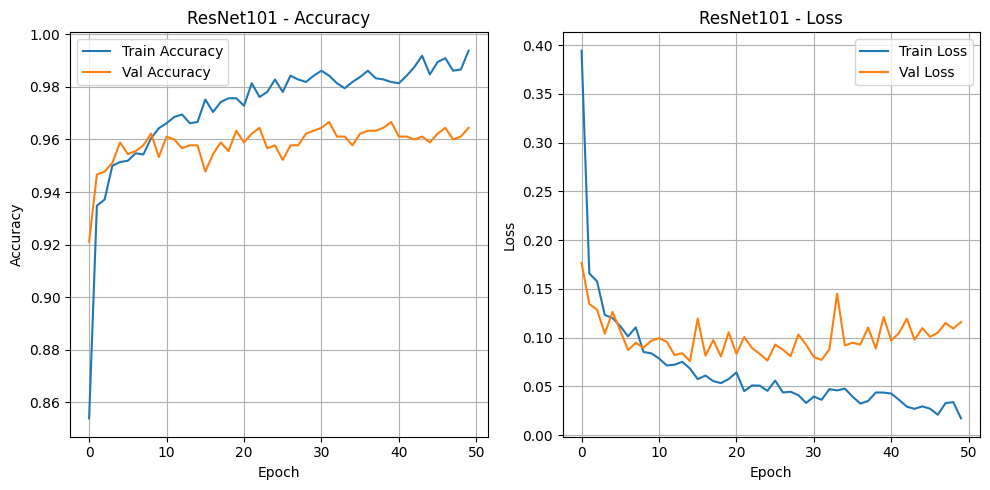

In [ ]:
#Plots for ResNet101 Accuracy and loss
plt.figure(figsize=(10, 5))

#Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_resnet101.history['accuracy'], label='Train Accuracy')
plt.plot(history_resnet101.history['val_accuracy'], label='Val Accuracy')
plt.title('ResNet101 - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

#Loss
plt.subplot(1, 2, 2)
plt.plot(history_resnet101.history['loss'], label='Train Loss')
plt.plot(history_resnet101.history['val_loss'], label='Val Loss')
plt.title('ResNet101 - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
#Prediction on validation data
val_pred_resnet101 = model_resnet101.predict(val_data_resnet)
y_pred_resnet101 = np.argmax(val_pred_resnet101, axis=1)

y_true_resnet101 = val_data_resnet.classes

class_names = list(val_data_resnet.class_indices.keys())

29/29 ━━━━━━━━━━━━━━━━━━━━ 25s 548ms/step


In [ ]:
# Classification report
report_resnet101 = classification_report(y_true_resnet101, y_pred_resnet101, target_names=class_names)
print("Classification Report - ResNet101")
print(report_resnet101)

Classification Report - ResNet101
                         precision    recall  f1-score   support

 augmented_fresh_frames       0.98      0.94      0.96       330
   augmented_mid_frames       0.94      0.98      0.96       390
augmented_rotten_frames       0.99      0.98      0.99       180

               accuracy                           0.97       900
              macro avg       0.97      0.97      0.97       900
           weighted avg       0.97      0.97      0.97       900



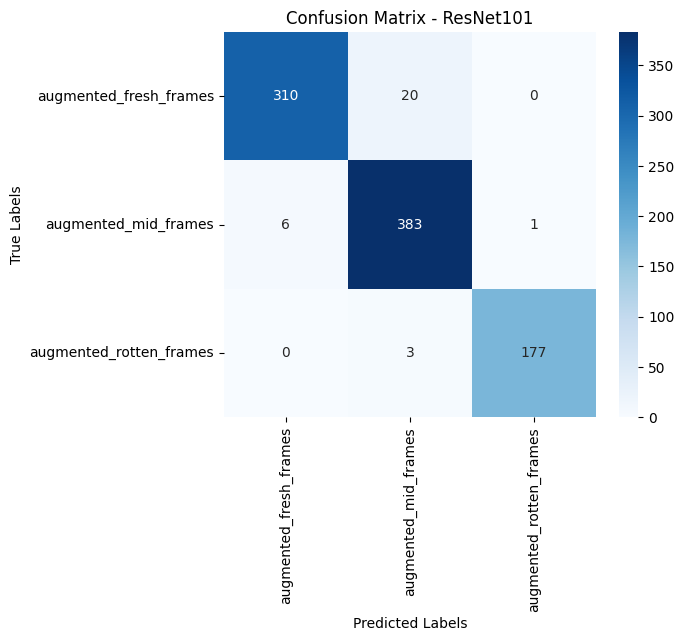

In [ ]:
#Confusion matrix
cm_resnet101 = confusion_matrix(y_true_resnet101, y_pred_resnet101)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_resnet101, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - ResNet101")
plt.show()

## Xception

In [ ]:
#Scaling values using preprocess_input
from tensorflow.keras.applications.xception import Xception, preprocess_input

datagen_preprocessed = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.3
)

# Load training data using datagen_preprocessed
train_data_xception = datagen_preprocessed.flow_from_directory(
    base_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Load validation data using datagen_preprocessed
val_data_xception = datagen_preprocessed.flow_from_directory(
    base_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 2100 images belonging to 3 classes.
Found 900 images belonging to 3 classes.


In [ ]:
#Loading Xception
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

#model building
model_xception = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(3, activation='softmax')
])

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
#Compilation
model_xception.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#Summary
model_xception.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,386,795 (81.58 MB)

 Trainable params: 525,315 (2.00 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [ ]:
checkpoint_xception = ModelCheckpoint(
    'best_model_xception.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

start_xception = time.time()

history_xception = model_xception.fit(
    train_data_xception,
    epochs=50,
    validation_data=val_data_xception,
    callbacks=[checkpoint_xception]
)

end_xception = time.time()
runtime_xception = end_xception - start_xception

print(f"Training Time for Xception model: {runtime_xception:.2f} seconds")

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.7704 - loss: 0.6110
Epoch 1: val_accuracy improved from -inf to 0.90556, saving model to best_model_xception.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 49s 531ms/step - accuracy: 0.7714 - loss: 0.6085 - val_accuracy: 0.9056 - val_loss: 0.2665
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.9106 - loss: 0.2429
Epoch 2: val_accuracy improved from 0.90556 to 0.92556, saving model to best_model_xception.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 25s 369ms/step - accuracy: 0.9107 - loss: 0.2426 - val_accuracy: 0.9256 - val_loss: 0.1718
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9320 - loss: 0.1704
Epoch 3: val_accuracy improved from 0.92556 to 0.94222, saving model to best_model_xception.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 24s 366ms/step - accuracy: 0.9320 - loss: 0.1704 - val_accuracy: 0.9422 - val_loss: 0.1568
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9461 - loss: 0.1433
Epoch 4: val_accuracy did not improve from 0.94222
66/66 ━━━━━━━━━━━━━━━━━━━━ 24s 363ms/step - accuracy: 0.9461 - loss: 0.1433 - val_accuracy: 0.9400 - val_loss: 0.1333
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.9602 - loss: 0.1071
Epoch 5: val_accuracy improved from 0.94222 to 0.95000, saving model to best_model_xception.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 23s 352ms/step - accuracy: 0.9602 - loss: 0.1072 - val_accuracy: 0.9500 - val_loss: 0.1248
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.9531 - loss: 0.1083
Epoch 6: val_accuracy improved from 0.95000 to 0.95222, saving model to best_model_xception.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 42s 367ms/step - accuracy: 0.9531 - loss: 0.1084 - val_accuracy: 0.9522 - val_loss: 0.1118
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.9651 - loss: 0.0903
Epoch 7: val_accuracy did not improve from 0.95222
66/66 ━━━━━━━━━━━━━━━━━━━━ 24s 364ms/step - accuracy: 0.9650 - loss: 0.0904 - val_accuracy: 0.9489 - val_loss: 0.1241
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.9702 - loss: 0.0807
Epoch 8: val_accuracy improved from 0.95222 to 0.95333, saving model to best_model_xception.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 23s 355ms/step - accuracy: 0.9701 - loss: 0.0809 - val_accuracy: 0.9533 - val_loss: 0.1119
Epoch 9/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.9717 - loss: 0.0753
Epoch 9: val_accuracy did not improve from 0.95333
66/66 ━━━━━━━━━━━━━━━━━━━━ 24s 359ms/step - accuracy: 0.9717 - loss: 0.0753 - val_accuracy: 0.9467 - val_loss: 0.1566
Epoch 10/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9609 - loss: 0.0981
Epoch 10: val_accuracy did not improve from 0.95333
66/66 ━━━━━━━━━━━━━━━━━━━━ 44s 405ms/step - accuracy: 0.9610 - loss: 0.0979 - val_accuracy: 0.9511 - val_loss: 0.1114
Epoch 11/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.9740 - loss: 0.0684
Epoch 11: val_accuracy did not improve from 0.95333
66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 406ms/step - accuracy: 0.9740 - loss: 0.0684 - val_accuracy: 0.9511 - val_loss: 0.1254
Epoch 12/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.9661 - loss: 0.0741
Epoch 12: val_accuracy imp

66/66 ━━━━━━━━━━━━━━━━━━━━ 24s 362ms/step - accuracy: 0.9662 - loss: 0.0740 - val_accuracy: 0.9567 - val_loss: 0.1111
Epoch 13/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.9780 - loss: 0.0589
Epoch 13: val_accuracy did not improve from 0.95667
66/66 ━━━━━━━━━━━━━━━━━━━━ 23s 350ms/step - accuracy: 0.9779 - loss: 0.0589 - val_accuracy: 0.9500 - val_loss: 0.1242
Epoch 14/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.9774 - loss: 0.0494
Epoch 14: val_accuracy did not improve from 0.95667
66/66 ━━━━━━━━━━━━━━━━━━━━ 24s 359ms/step - accuracy: 0.9774 - loss: 0.0495 - val_accuracy: 0.9522 - val_loss: 0.1232
Epoch 15/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9699 - loss: 0.0643
Epoch 15: val_accuracy improved from 0.95667 to 0.95778, saving model to best_model_xception.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 24s 361ms/step - accuracy: 0.9700 - loss: 0.0642 - val_accuracy: 0.9578 - val_loss: 0.1184
Epoch 16/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.9763 - loss: 0.0551
Epoch 16: val_accuracy did not improve from 0.95778
66/66 ━━━━━━━━━━━━━━━━━━━━ 24s 357ms/step - accuracy: 0.9763 - loss: 0.0553 - val_accuracy: 0.9556 - val_loss: 0.1303
Epoch 17/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.9759 - loss: 0.0650
Epoch 17: val_accuracy did not improve from 0.95778
66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 402ms/step - accuracy: 0.9758 - loss: 0.0651 - val_accuracy: 0.9500 - val_loss: 0.1286
Epoch 18/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.9735 - loss: 0.0718
Epoch 18: val_accuracy did not improve from 0.95778
66/66 ━━━━━━━━━━━━━━━━━━━━ 24s 360ms/step - accuracy: 0.9735 - loss: 0.0717 - val_accuracy: 0.9522 - val_loss: 0.1316
Epoch 19/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.9796 - loss: 0.0493
Epoch 19: val_accuracy d

66/66 ━━━━━━━━━━━━━━━━━━━━ 24s 357ms/step - accuracy: 0.9851 - loss: 0.0367 - val_accuracy: 0.9600 - val_loss: 0.1189
Epoch 25/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.9892 - loss: 0.0275
Epoch 25: val_accuracy did not improve from 0.96000
66/66 ━━━━━━━━━━━━━━━━━━━━ 24s 362ms/step - accuracy: 0.9892 - loss: 0.0276 - val_accuracy: 0.9533 - val_loss: 0.1359
Epoch 26/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.9834 - loss: 0.0397
Epoch 26: val_accuracy did not improve from 0.96000
66/66 ━━━━━━━━━━━━━━━━━━━━ 23s 354ms/step - accuracy: 0.9835 - loss: 0.0397 - val_accuracy: 0.9578 - val_loss: 0.1400
Epoch 27/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.9905 - loss: 0.0315
Epoch 27: val_accuracy did not improve from 0.96000
66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 407ms/step - accuracy: 0.9904 - loss: 0.0317 - val_accuracy: 0.9600 - val_loss: 0.1186
Epoch 28/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.9694 - loss: 0.0541
Epoch 28: val_accuracy d

66/66 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9889 - loss: 0.0257 - val_accuracy: 0.9644 - val_loss: 0.1390
Epoch 46/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.9950 - loss: 0.0211
Epoch 46: val_accuracy did not improve from 0.96444
66/66 ━━━━━━━━━━━━━━━━━━━━ 24s 370ms/step - accuracy: 0.9951 - loss: 0.0210 - val_accuracy: 0.9567 - val_loss: 0.1709
Epoch 47/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.9965 - loss: 0.0161
Epoch 47: val_accuracy did not improve from 0.96444
66/66 ━━━━━━━━━━━━━━━━━━━━ 23s 343ms/step - accuracy: 0.9965 - loss: 0.0161 - val_accuracy: 0.9578 - val_loss: 0.1544
Epoch 48/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.9930 - loss: 0.0139
Epoch 48: val_accuracy did not improve from 0.96444
66/66 ━━━━━━━━━━━━━━━━━━━━ 24s 366ms/step - accuracy: 0.9930 - loss: 0.0139 - val_accuracy: 0.9589 - val_loss: 0.1528
Epoch 49/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.9834 - loss: 0.0287
Epoch 49: val_accuracy d

In [ ]:
model_xception = load_model("best_model_xception.h5")

In [ ]:
loss_xception, accuracy_xception = model_xception.evaluate(val_data_xception)
print(f"Validation Accuracy: {accuracy_xception:.4f}, Validation Loss: {loss_xception:.4f}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 294ms/step - accuracy: 0.9654 - loss: 0.1370
Validation Accuracy: 0.9644, Validation Loss: 0.1390


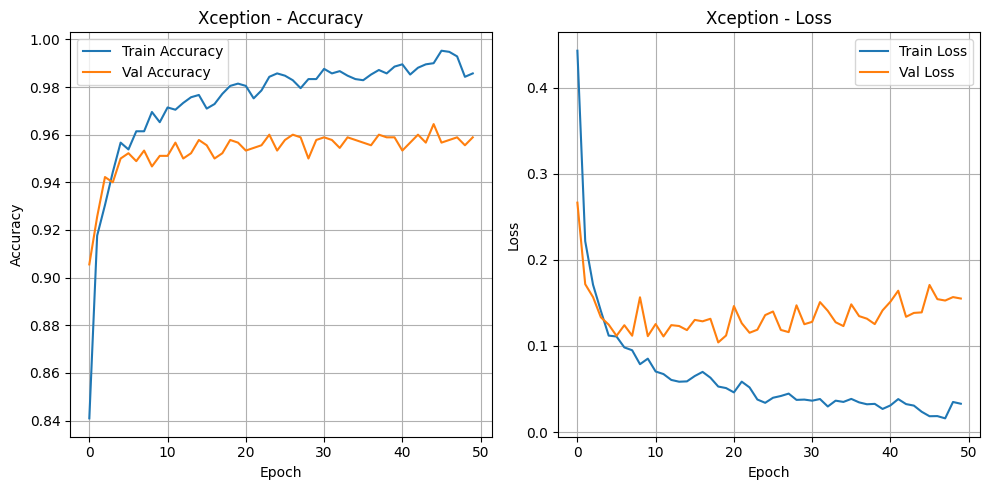

In [ ]:
#Plots for Xception Accuracy and loss
plt.figure(figsize=(10, 5))

#Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_xception.history['accuracy'], label='Train Accuracy')
plt.plot(history_xception.history['val_accuracy'], label='Val Accuracy')
plt.title('Xception - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

#Loss
plt.subplot(1, 2, 2)
plt.plot(history_xception.history['loss'], label='Train Loss')
plt.plot(history_xception.history['val_loss'], label='Val Loss')
plt.title('Xception - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
#Prediction on validation data
val_pred_xception = model_xception.predict(val_data_xception)
y_pred_xception = np.argmax(val_pred_xception, axis=1)

y_true_xception = val_data_xception.classes

class_names = list(val_data_xception.class_indices.keys())

29/29 ━━━━━━━━━━━━━━━━━━━━ 284s 10s/step


In [ ]:
# Classification report
report_xception = classification_report(y_true_xception, y_pred_xception, target_names=class_names)
print("Classification Report - Xception")
print(report_xception)

Classification Report - Xception
                         precision    recall  f1-score   support

 augmented_fresh_frames       0.95      0.96      0.96       330
   augmented_mid_frames       0.96      0.96      0.96       390
augmented_rotten_frames       0.99      0.98      0.99       180

               accuracy                           0.96       900
              macro avg       0.97      0.97      0.97       900
           weighted avg       0.96      0.96      0.96       900



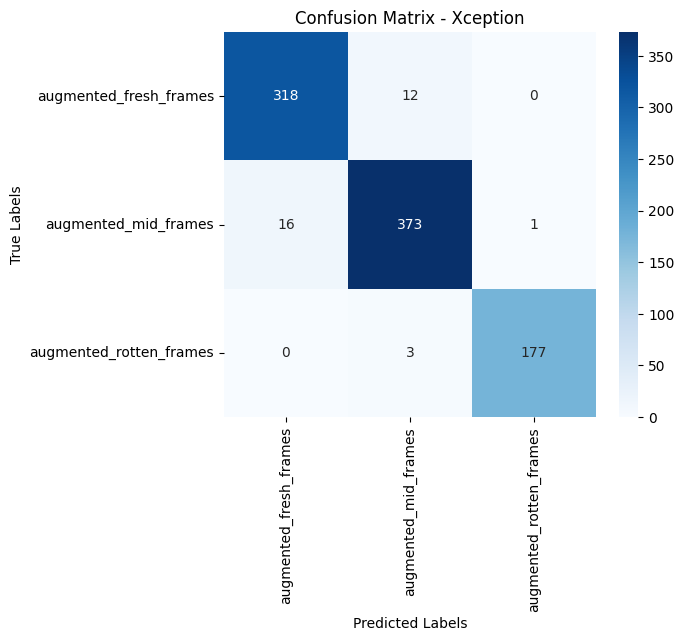

In [ ]:
#confusion matrix
cm_xception = confusion_matrix(y_true_xception, y_pred_xception)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_xception, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - Xception")
plt.show()